<a href="https://colab.research.google.com/github/lcipolina/escher/blob/master/ML/LaMa_CoModGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦙 **LaMa: Resolution-robust Large Mask Inpainting with Fourier Convolutions**

[[Project page](https://saic-mdal.github.io/lama-project/)] [[GitHub](https://github.com/saic-mdal/lama)] [[arXiv](https://arxiv.org/abs/2109.07161)] [[Supplementary](https://ashukha.com/projects/lama_21/lama_supmat_2021.pdf)] [[BibTeX](https://senya-ashukha.github.io/projects/lama_21/paper.txt)]

<p align="center" "font-size:30px;">
Our model generalizes surprisingly well to much higher resolutions (~2k❗️) than it saw during training (256x256), and achieves the excellent performance even in challenging scenarios, e.g. completion of periodic structures.
</p>




In [1]:
#Imports

!pip install wget --quiet

import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil

### LaMa

In [2]:
#@title Run this sell to set everything up
print('\n> Cloning the repo')
!git clone https://github.com/saic-mdal/lama.git

print('\n> Install dependencies')
!pip install -r lama/requirements.txt --quiet

print('\n> Changing the dir to:')
% cd /content/lama

print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip


> Cloning the repo
Cloning into 'lama'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 266 (delta 64), reused 262 (delta 64), pack-reused 0
Receiving objects: 100% (266/266), 6.49 MiB | 11.34 MiB/s, done.
Resolving deltas: 100% (64/64), done.

> Install dependencies
     |████████████████████████████████| 12.5 MB 4.2 MB/s 
     |████████████████████████████████| 22.3 MB 47.8 MB/s 
     |████████████████████████████████| 72 kB 627 kB/s 
     |████████████████████████████████| 144 kB 41.9 MB/s 
     |████████████████████████████████| 841 kB 42.8 MB/s 
     |████████████████████████████████| 271 kB 43.9 MB/s 
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 948 kB 35.3 MB/s 
     |████████████████████████████████| 47.6 MB 80 kB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 112 kB 50.

Mask drawing code

In [3]:
print('\n> Init mask-drawing code')

canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


> Init mask-drawing code


#### Upload an image
*Predefined photo:* uncomment any line

**Local file:** leave the *fname = None*


In [4]:
#fname = None
fname = 'https://ic.pics.livejournal.com/mostovoy/28566193/1224276/1224276_original.jpg' # <-in the example
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010286.jpeg'
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010287.jpeg'
# fname = "https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/alex.jpg"

if fname is None:
  from google.colab import files
  files = files.upload()
  fname = list(files.keys())[0]
else:
  fname = wget.download(fname)

### Call the drawing function

Draw a Mask, Press Finish, Wait for Inpainting

Will use ./data_for_prediction/1224276_original.jpg for inpainting


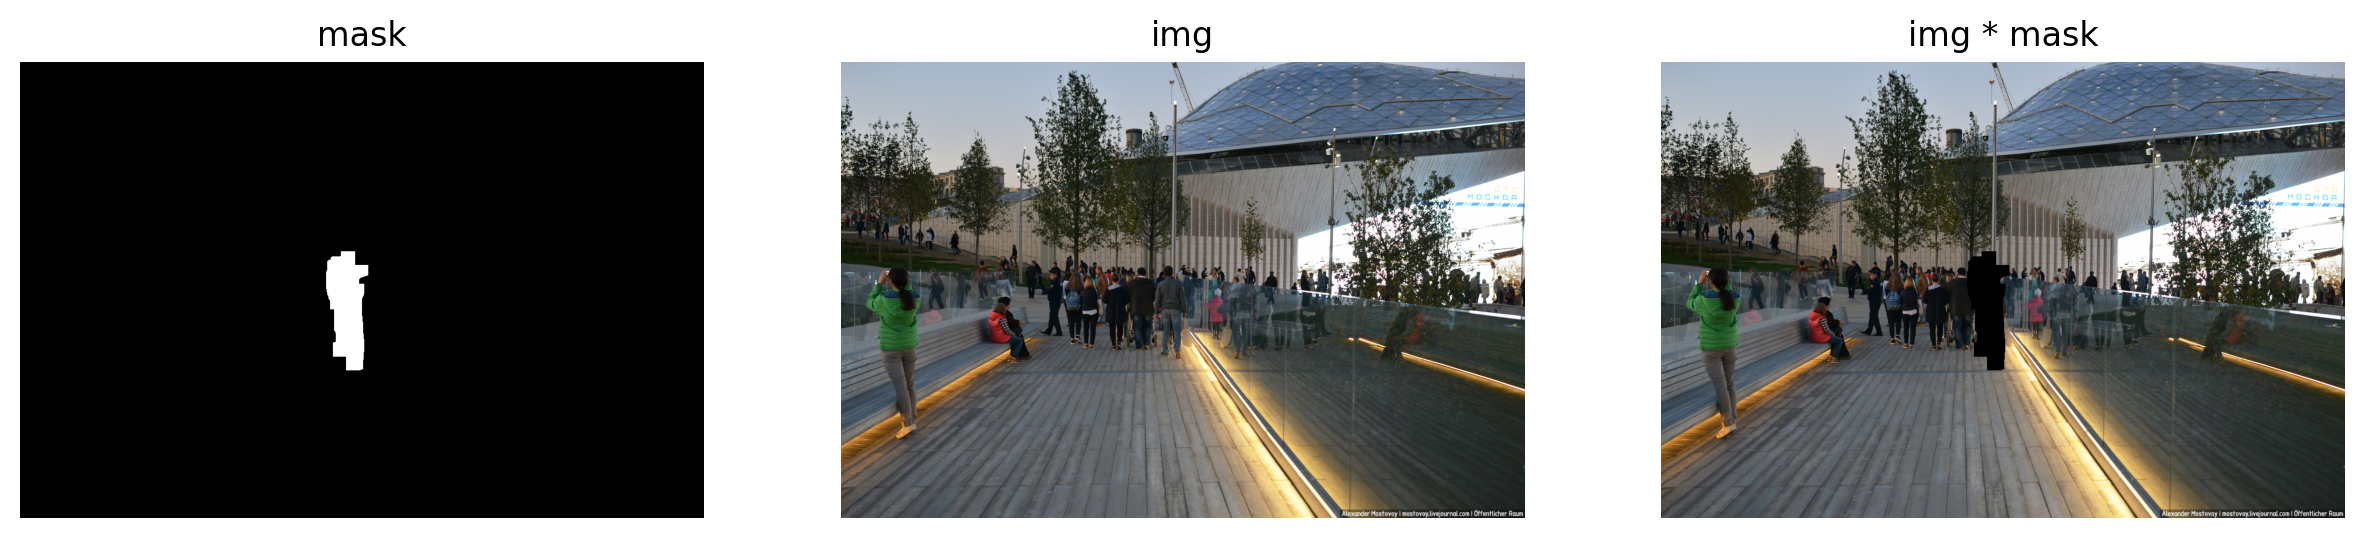

Run inpainting
100% 1/1 [00:01<00:00,  1.79s/it]


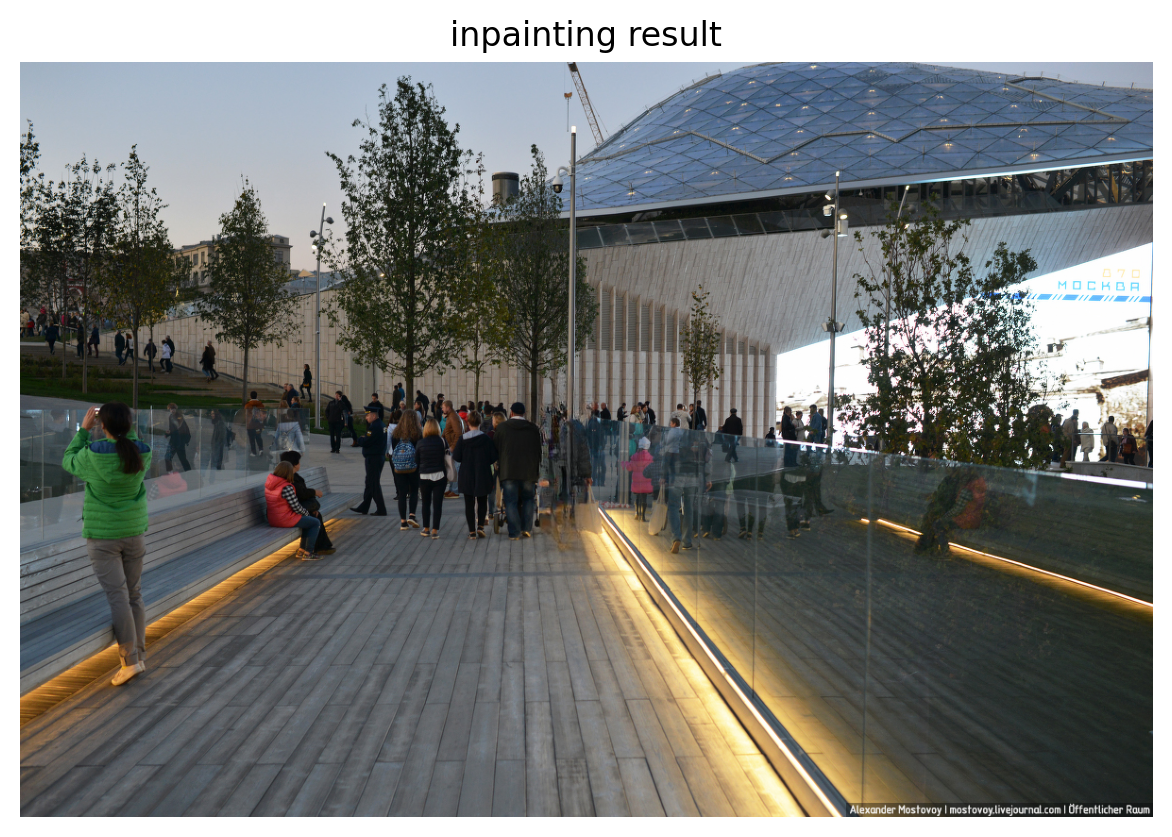

In [5]:
#Draw a Mask, Press Finish, Wait for Inpainting

shutil.rmtree('./data_for_prediction', ignore_errors=True)
! mkdir data_for_prediction

copyfile(fname, f'./data_for_prediction/{fname}')
os.remove(fname)
fname = f'./data_for_prediction/{fname}'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])


#Mask drawing function
draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])


#Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')

plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray') #save on 'data_for_prediction' folder

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None

### CoModGan

Switch to tensorflow 1.x 

In [6]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [7]:
!nvidia-smi 

Mon Dec 13 09:03:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Clone the repo

In [8]:
!git clone https://github.com/zsyzzsoft/co-mod-gan.git

Cloning into 'co-mod-gan'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 126 (delta 52), reused 104 (delta 30), pack-reused 0
Receiving objects: 100% (126/126), 8.68 MiB | 9.02 MiB/s, done.
Resolving deltas: 100% (52/52), done.


### Test the model on custom mask and images

Add your input image and mask to the imgs folder and run the below cell. The output will be saved as output.jpg

In [9]:
%cd co-mod-gan/

/content/lama/co-mod-gan


Download the model, copy the id from the drive link.
Example: The ascii after folders/ and before ? in the below link: https://drive.google.com/drive/folders/1tpcwAr2aSNLouoBdeQuW2fCL8v1kAVhS?usp=sharing

In [10]:
!gdown --id 19EReeIpTqSrO9QomJ49XVYNHGKxkFL1K

Downloading...
From: https://drive.google.com/uc?id=19EReeIpTqSrO9QomJ49XVYNHGKxkFL1K
To: /content/lama/co-mod-gan/network-snapshot-050060.pkl
100% 760M/760M [00:06<00:00, 110MB/s]


Now add the image and mask to `imgs/`. 

The part of the image that has to be predicted by the model should be in black and the rest in white

In the below code `-c` is for the model, `-i` is for the input image path, `-m` is for mask and `-o` is for path of output

In [6]:
!python run_generator.py -c "/content/co-mod-gan/network-snapshot-050060.pkl" -i imgs/1.jpg -m imgs/1_mask.jpg -o output.jpg

Traceback (most recent call last):
  File "run_generator.py", line 34, in <module>
    main()
  File "run_generator.py", line 31, in main
    generate(**vars(args))
  File "run_generator.py", line 9, in generate
    real = np.asarray(PIL.Image.open(image)).transpose([2, 0, 1])
  File "/usr/local/lib/python3.7/dist-packages/PIL/Image.py", line 2843, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: 'imgs/1.jpg'
